In [49]:
import alpha_vantage
from alpha_vantage.timeseries import TimeSeries

In [50]:
APIkey = "2SRLF3NBCPEO7UI5"

from alpha_vantage.timeseries import TimeSeries

ts = TimeSeries(key=APIkey, output_format="pandas")
data, _ = ts.get_daily(symbol="TSLA", outputsize="full")
data

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2024-08-16,211.15,219.8000,210.80,216.12,88487970.0
2024-08-15,205.02,215.8800,204.82,214.14,89848530.0
2024-08-14,207.39,208.4400,198.75,201.38,70250014.0
2024-08-13,198.47,208.4900,197.06,207.83,76247387.0
2024-08-12,199.02,199.2600,194.67,197.49,64044903.0
...,...,...,...,...,...
2010-07-06,20.00,20.0000,15.83,16.11,6866900.0
2010-07-02,23.00,23.1000,18.71,19.20,5139800.0
2010-07-01,25.00,25.9200,20.27,21.96,8218800.0


# Cholesky Decomposition

Cholesky factorization is a decomposition of a <u> positive-definite </u>, <u> symmetric matrix </u> into a product of a triangular matrix and its conjugate transpose:

$ C = L L^T $

where,

$C:$ $(d \times d)$ **correlation** matrix of $d$ different stock rate of returns.

$L:$ $(d \times d)$ lower triangular Cholesky matrix, which will be used to multiply $d$ standard random variables $Z_i \quad i.i.d \sim N(0, 1)$ to create new <u> correlated</u> values (stock returns).

To create correlated values using the **Cholesky** matrix $L$,

$Z = \begin{bmatrix}
Z_1 \\
Z_2 \\
\cdots \\
Z_d
\end{bmatrix}
$ where $Z_i \quad iid \sim N(0, 1)$

Then we multiply Cholesky matrix $L$ with our standard gaussian vector $Z$ to obtain correlated values vector $\epsilon:$

$\epsilon = L Z$

In [51]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

tickers = ["AAPL", "AMZN", "META", "GOOG", "MSFT"]
df_tickers = yf.download(tickers, period="10y")["Adj Close"]
df_tickers.head()

[*********************100%%**********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOG,META,MSFT
Date,,,,,
2014-08-18,22.011221,16.7265,28.995308,74.437035,38.330498
2014-08-19,22.315329,16.7565,29.229397,75.135605,38.758022
2014-08-20,22.324211,16.7890,29.111357,74.656578,38.433102
2014-08-21,22.326427,16.6455,29.055573,74.417084,38.663963
2014-08-22,22.490700,16.5795,29.015230,74.417084,38.604107


In [52]:
df_returns = (df_tickers.diff() / df_tickers).dropna()
df_returns.head()

Ticker,AAPL,AMZN,GOOG,META,MSFT
Date,,,,,
2014-08-19,0.013628,0.001790,0.008009,0.009297,0.011031
2014-08-20,0.000398,0.001936,-0.004055,-0.006416,-0.008454
2014-08-21,0.000099,-0.008621,-0.001920,-0.003218,0.005971
2014-08-22,0.007304,-0.003981,-0.001390,0.000000,-0.001551
2014-08-25,0.002166,0.007275,-0.004068,0.005998,0.000443


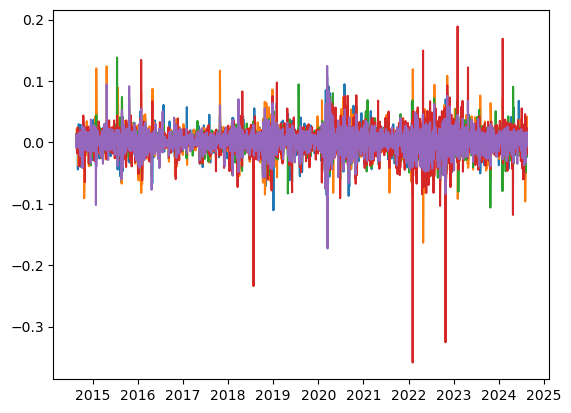

In [53]:
plt.plot(df_returns)

In [54]:
# Volatilities
sigma = df_returns.std()
sigma

Ticker
AAPL    0.018010
AMZN    0.020522
GOOG    0.017753
META    0.024338
MSFT    0.017100
dtype: float64

In [55]:
corr_matrix = df_returns.corr()  # Correlation matrix
corr_matrix

Ticker,AAPL,AMZN,GOOG,META,MSFT
Ticker,,,,,
AAPL,1.000000,0.558758,0.611860,0.517300,0.684624
AMZN,0.558758,1.000000,0.654694,0.580080,0.648673
GOOG,0.611860,0.654694,1.000000,0.616157,0.722036
META,0.517300,0.580080,0.616157,1.000000,0.574568
MSFT,0.684624,0.648673,0.722036,0.574568,1.000000


In [56]:
L = np.linalg.cholesky(corr_matrix)
L

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.55875781, 0.82933088, 0.        , 0.        , 0.        ],
       [0.61186027, 0.37718682, 0.69523889, 0.        , 0.        ],
       [0.51729959, 0.3509267 , 0.24060384, 0.74253712, 0.        ],
       [0.68462399, 0.32090226, 0.26192704, 0.06030425, 0.59671547]])

In [57]:
# Check if L @ L^T equals corr_matrix
np.isclose(L @ L.T, corr_matrix)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [58]:
d = L.shape[0]  # dimension of the price vector

# Generate a standard gaussian vector z
z = np.random.standard_normal(d)

# Generate a correlated values vector
epsilon = L @ z
epsilon

array([ 0.90581055,  0.37703876, -0.03483338,  0.1645488 ,  0.33418037])

With all the previous inputs, we can now simulate price paths using the "classic" price process:

$$
\begin{equation}
S_t = S_{t-1} e^{\left(\left(r - \frac{\sigma^2}{2}\right)dt + \sigma ϵ \sqrt{dt}\right)}
\end{equation}
$$

In [59]:
S0 = 100
T = 252  # days
L = np.linalg.cholesky(corr_matrix)  # Generate the (d, d) Cholesky matrix after decomposition
d = L.shape[0]  # dimension of the price vector
r = 0.001  # risk-free rate

S = np.zeros((T+1, d))
Z = np.random.standard_normal((T, d))  # generate T different Z vectors of shape (T, d)
epsilon = (L @ Z.T).T  # generates (T, d) shaped matrix where rows are correlated random variable values
print("epsilon.shape =", epsilon.shape)

dt = 1 / T  # Timestep is a business day (here written in years)
sigma = df_returns.std().to_numpy()  # individual volatilities from the returns df, shape (d,)
print("sigma.shape =", sigma.shape)
sigma_reshaped = sigma.reshape(1, -1)  # Shape: (1, d)
multipliers = np.exp((r - sigma_reshaped**2/2)*dt + sigma_reshaped*epsilon*np.sqrt(dt))
print("multipliers.shape =", multipliers.shape)
print("multipliers =\n", multipliers)

# Create the paths
S[0] = S0  # First row is the starting price
S[1:, :] = S0 * np.cumprod(multipliers, axis=0)
S

epsilon.shape = (252, 5)
sigma.shape = (5,)
multipliers.shape = (252, 5)
multipliers =
 [[1.00068352 0.99896682 0.99864973 0.99877743 1.00058279]
 [0.99949534 0.99836031 0.9987535  0.99878663 0.99869242]
 [1.00067666 1.00071172 1.00151626 1.00259442 1.00135568]
 ...
 [0.99968938 0.99982653 1.00022332 0.99819704 0.99914198]
 [1.00110855 1.00201723 1.00164904 1.00266797 1.0008607 ]
 [1.00109483 1.00032571 0.9997362  1.00138214 1.00005506]]


array([[100.        , 100.        , 100.        , 100.        ,
        100.        ],
       [100.06835248,  99.89668202,  99.86497342,  99.87774251,
        100.05827893],
       [100.01785183,  99.73288202,  99.74049167,  99.75655351,
         99.92744499],
       ...,
       [102.26080921,  98.98145232,  98.03503451, 101.25490024,
         99.71172991],
       [102.37417084,  99.18112077,  98.19669795, 101.52504558,
         99.79755155],
       [102.48625313,  99.21342472,  98.17079335, 101.66536766,
         99.80304636]])

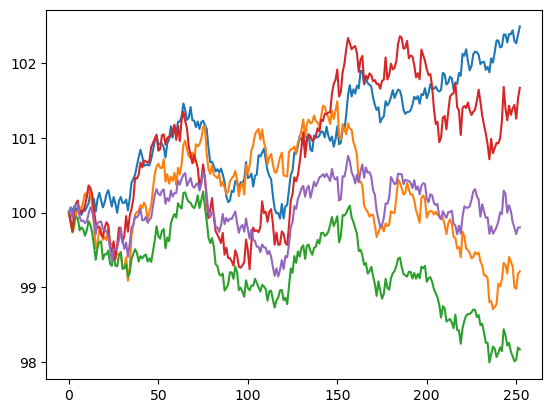

In [60]:
plt.plot(S)